In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import anndata as ad
import skimage
import matplotlib.pyplot as plt
from pathlib import Path


# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tangram=={tg.__version__}")

scanpy==1.9.6 anndata==0.10.8 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.11
squidpy==1.2.2
tangram==1.0.4


# Including PKD samples (Muto24)

In [2]:
atlas = sc.read_h5ad("/exports/archive/hg-groep-peters/snRNAseq_Cesare_Claudio_Early_Mod_Severe/snRNAseq/MKA_Extended/mka_extended_pkd_innerjoin.h5ad")

In [3]:
library_id = 'pkd_3'

In [4]:
output_dir = f'/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/{library_id.lower()}_v1/'

In [5]:
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [5]:
adata_sc = sc.read_h5ad("/exports/archive/hg-groep-peters/snRNAseq_Cesare_Claudio_Early_Mod_Severe/snRNAseq/MKA_Extended/mka_extended_pkd_innerjoin_normalised_expression.h5ad")
adata_st = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/h5ad/spatial_processed.h5ad")
adata_st = adata_st[adata_st.obs.library_id == library_id].copy()
img = sq.im.ImageContainer.load('/exports/humgen/cnovellarausell/SevtapSpatial/zarr/full{}_segmented_Cellpose_0.8_1'.format(library_id))

In [6]:
adata_sc = adata_sc[~adata_sc.obs.Predicted_Celltype.isin(['Unknown'])].copy()

In [7]:
adata_st.X = adata_st.layers['LogNorm'].copy()

In [8]:
sq.im.calculate_image_features(
    adata_st,
    img,
    layer =  library_id,
    library_id = library_id,
    features="segmentation",
    key_added="segmentation_features",
    features_kwargs={
        "segmentation": {
            "label_layer": "segmented_custom",
            "props": ["label", "centroid"]
        }
    },
    mask_circle=True,
    n_jobs=3,
    show_progress_bar = True    
    )

  0%|          | 0/2213 [00:00<?, ?/s]

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/squidpy/im/_container.py:1371: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.data.dims["y"], self.data.dims["x"]
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/squidpy/im/_container.py:606: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if data.dims["y"] != data.dims["x"]:
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/squidpy/im/_container.py:1371: Future

In [9]:
adata_st.obs["cell_count"] = adata_st.obsm["segmentation_features"]["segmentation_label"] # number of nuclei per voxel

In [10]:
adata_st.obs["cell_count"].sum()

57883

In [11]:
adata_sc

AnnData object with n_obs × n_vars = 303791 × 12156
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'total_counts', 'n_genes_by_counts', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'percent.mt', 'nucleosome_signal', 'TSS.enrichment', 'nCount_peaks', 'nFeature_peaks', 'disease', 'celltype', 'wnnUMAP_1', 'wnnUMAP_2', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'batch', 'labels_scanvi'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [12]:
adata_sc.obs.groupby(['Predicted_Celltype']).Origin.value_counts().to_csv('celltype_origin.csv')

In [13]:
def ct_adata(adata, obs_column):
    adata_dict = {}
    for i in set(adata.obs[obs_column]):
         adata_dict[i] = adata[adata.obs[obs_column] == i].copy()
    return adata_dict

def subsample_atlas(adata_dict, proportions, nr_cells):
    proportions.sort_values('Fraction', axis=0, ascending=False, inplace=True)
    
    # Filter out cell types with only one sample in the original adata_dict
    adata_dict = {ct: adata for ct, adata in adata_dict.items() if len(adata) > 1}
    
    for cell_type in proportions.index.to_list():
        if cell_type not in adata_dict:
            print(f"Skipping {cell_type} because it contains only one sample in the original data.")
            continue
        
        obs_to_sample = round(proportions.loc[cell_type]['Fraction'] * nr_cells)
        
        # Skip sampling if the number to sample is 1 or less
        if obs_to_sample <= 1:
            print(f"Skipping {cell_type} because the calculated sample size is {obs_to_sample}.")
            continue

        available_cells = len(adata_dict[cell_type])
        
        if available_cells >= obs_to_sample:
            sc.pp.subsample(adata_dict[cell_type], n_obs=obs_to_sample, random_state=0, copy=False)
        else:
            print(f"{cell_type}: Only {available_cells} available, but {obs_to_sample} requested.")
    
    return ad.concat(adata_dict.values())


In [14]:
def subsample_atlas_excluding_origins(adata_dict, proportions, nr_cells, exclude_origins=("Muto24", "Humphreys23")):
    """
    Subsample cells from each cell type dictionary entry (adata_dict),
    but exclude cells whose .obs['Origin'] is in exclude_origins.
    
    Parameters
    ----------
    adata_dict : dict[str, anndata.AnnData]
        A dictionary keyed by cell-type, each value is an AnnData with cells of that type.
    proportions : pd.DataFrame
        DataFrame with index as cell types and a 'Fraction' column indicating the 
        fraction of total cells we want for each cell type.
    nr_cells : int
        Total number of cells to sample across all cell types.
    exclude_origins : tuple[str], optional
        Origins to exclude (default: ("Muto24", "Humphreys23")).

    Returns
    -------
    anndata.AnnData
        An AnnData object concatenated from the newly subsampled cell types.
    """

    # Sort proportions by highest Fraction first (so bigger cell types are processed first)
    proportions.sort_values('Fraction', axis=0, ascending=False, inplace=True)

    # 1) Exclude Muto24 / Humphreys23 from each AnnData
    #    and build a new dictionary with those filtered data
    filtered_adata_dict = {}
    for cell_type, adata in adata_dict.items():
        # Exclude rows with .obs['Origin'] in the specified tuple
        keep_mask = ~adata.obs['Origin'].isin(exclude_origins)
        filtered_adata = adata[keep_mask].copy()
        
        # Keep only if at least 1 cells remain
        if len(filtered_adata) < 1:
            print(f"Skipping {cell_type} because after excluding {exclude_origins}, fewer than 2 cells remain.")
        else:
            filtered_adata_dict[cell_type] = filtered_adata

    # 2) Filter out cell types that have only 1 sample in the original filtered dictionary
    filtered_adata_dict = {ct: adata for ct, adata in filtered_adata_dict.items()
                           if len(adata) > 1}

    # 3) Subsampling loop
    for cell_type in proportions.index.to_list():
        if cell_type not in filtered_adata_dict:
            print(f"Skipping {cell_type} because it has <2 cells after excluding {exclude_origins} or was not found.")
            continue
        
        obs_to_sample = round(proportions.loc[cell_type]['Fraction'] * nr_cells)
        
        # Skip sampling if the number to sample is 1 or less
        if obs_to_sample <= 1:
            print(f"Skipping {cell_type} because the calculated sample size is {obs_to_sample}.")
            continue

        available_cells = len(filtered_adata_dict[cell_type])

        if available_cells >= obs_to_sample:
            sc.pp.subsample(filtered_adata_dict[cell_type],
                            n_obs=obs_to_sample,
                            random_state=0,
                            copy=False)
        else:
            print(f"{cell_type}: Only {available_cells} available, but {obs_to_sample} requested.")

    # 4) Concatenate all subsampled AnnData objects
    if filtered_adata_dict:
        return ad.concat(filtered_adata_dict.values(), merge='same')
    else:
        print("No cell types remain after filtering and subsampling.")
        return None

In [15]:
adata_dict = ct_adata(adata_sc, 'Predicted_Celltype')

In [16]:
proportions = pd.read_csv(f'/exports/humgen/cnovellarausell/SevtapSpatial/cytospace/{library_id.lower()}_withatlas_cell_fractions_ZimmermanHumphreysMuto_highres_remapped_noint.tsv', sep='\t', index_col=0)

In [17]:
proportions = proportions.T

In [18]:
mapping = {
    'DTL ATL': 'DTL-ATL',
    'DCT CNT': 'DCT-CNT',
    'Glom Endo': 'Glom-Endo',
    'CD Trans': 'CD-Trans',
    'T3 Follicular B lymph': 'T3/Follicular B lymph',
    'CD4  T regs': 'CD4+ T regs',
    'CD4  T lymph': 'CD4+ T lymph',
    'CD4  Th17': 'CD4+ Th17',
    'Spp1  Resident Macrophages ':'Spp1+ Resident Macrophages ',
    'Gzma  CD8  T lymph': 'Gzma+ CD8+ T lymph',
    'Mrc1  Resident Macrophages':'Mrc1+ Resident Macrophages',
    'Gzma  NK':'Gzma+ NK',
    'PT AcInj': 'PT-AcInj',
    'PT R': 'PT-R',
    'PT FR': 'PT-FR',
    'PT Inj': 'PT-Inj',
    'Trans PTC': 'Trans-PTC'}

proportions.rename(index=mapping, inplace=True)

In [22]:
adata_sc.obs.Origin.value_counts()

Origin
Humphreys23    95804
Muto24         57832
Hinze20        29443
Kirita20       25848
Park18         24443
Miao21         22265
Zimmerman22    13611
Wu19           10647
Dumas20         9257
Janosevic21     8964
Conway20        5677
Name: count, dtype: int64

In [23]:
adata_sc = subsample_atlas(adata_dict, proportions, adata_st.obs["cell_count"].sum())

CD-Trans: Only 59 available, but 665 requested.
Spp1+ Resident Macrophages : Only 246 available, but 480 requested.
Skipping T3/Follicular B lymph because the calculated sample size is 0.
Skipping T1 B lymph because the calculated sample size is 0.
Skipping CD4+ T lymph because the calculated sample size is 0.
Skipping Gzma+ CD8+ T lymph because the calculated sample size is 0.
Skipping DTL-ATL because the calculated sample size is 0.
Skipping Memory B lymph because the calculated sample size is 0.
Skipping PEC because the calculated sample size is 0.
Skipping NKT1 because the calculated sample size is 0.
Skipping NK because the calculated sample size is 0.
Skipping MD because the calculated sample size is 0.


In [24]:
adata_sc

AnnData object with n_obs × n_vars = 60808 × 12156
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'total_counts', 'n_genes_by_counts', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'percent.mt', 'nucleosome_signal', 'TSS.enrichment', 'nCount_peaks', 'nFeature_peaks', 'disease', 'celltype', 'wnnUMAP_1', 'wnnUMAP_2', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'batch', 'labels_scanvi'

In [25]:
adata_sc.X = adata_sc.X * 100000

In [26]:
adata_sc

AnnData object with n_obs × n_vars = 60808 × 12156
    obs: 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'Predicted_Celltype', 'Predicted_Celltype_lowres', 'sample', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'total_counts', 'n_genes_by_counts', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'percent.mt', 'nucleosome_signal', 'TSS.enrichment', 'nCount_peaks', 'nFeature_peaks', 'disease', 'celltype', 'wnnUMAP_1', 'wnnUMAP_2', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'batch', 'labels_scanvi'

In [27]:
sc.tl.rank_genes_groups(adata_sc, groupby="Predicted_Celltype", use_raw=False, method='wilcoxon')

In [28]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]

In [29]:
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_st.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))

In [30]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:3425 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:11925 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [36]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu"
)

Allocate tensors for mapping.
Begin training with 3011 genes and customized density_prior in constrained mode...
Score: 0.435, KL reg: 0.055, Count reg: 19349.918, Lambda f reg: 8464.836
Score: 0.490, KL reg: 0.003, Count reg: 460.875, Lambda f reg: 645.488
Score: 0.494, KL reg: 0.002, Count reg: 409.547, Lambda f reg: 687.216
Score: 0.495, KL reg: 0.002, Count reg: 296.617, Lambda f reg: 763.079
Score: 0.496, KL reg: 0.002, Count reg: 6.141, Lambda f reg: 874.989
Score: 0.496, KL reg: 0.002, Count reg: 10.203, Lambda f reg: 662.326
Score: 0.496, KL reg: 0.002, Count reg: 0.141, Lambda f reg: 539.779
Score: 0.496, KL reg: 0.002, Count reg: 0.180, Lambda f reg: 453.884
Score: 0.496, KL reg: 0.002, Count reg: 8.945, Lambda f reg: 387.478
Score: 0.496, KL reg: 0.002, Count reg: 8.547, Lambda f reg: 345.504
Saving results..


In [37]:
ad_map.write_h5ad(output_dir + f"probs_constrained_denoised_{library_id}_subsampled_zimmermanhumphreysmuto_highres.h5ad")

In [31]:
ad_map = sc.read_h5ad(output_dir + f"probs_constrained_denoised_{library_id}_subsampled_zimmermanhumphreysmuto_highres.h5ad")

In [38]:
adata_sc.write_h5ad(output_dir + f"adata_sc_constrained_denoised_{library_id}_subsampled_zimmermanhumphreysmuto_highres.h5ad")

In [32]:
adata_sc = sc.read_h5ad(output_dir + f"adata_sc_constrained_denoised_{library_id}_subsampled_zimmermanhumphreysmuto_highres.h5ad")

In [33]:
tg.project_cell_annotations(ad_map, adata_st, annotation="Predicted_Celltype")
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)
adata_st.obsm['image_features'] = adata_st.obsm['segmentation_features']

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

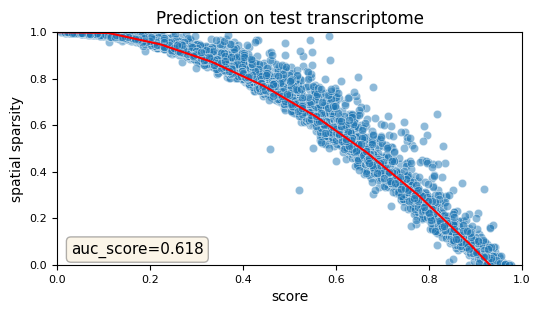

In [40]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
tg.plot_auc(df_all_genes);
plt.savefig(output_dir + f"auc_constrained_denoised_{library_id}_subsampled_zimmermanhumphreysmuto_highres.svg")

In [35]:
tg.create_segment_cell_df(adata_st)

INFO:root:cell segmentation dataframe is saved in `uns` `tangram_cell_segmentation` of the spatial AnnData.
INFO:root:spot centroids is saved in `obsm` `tangram_spot_centroids` of the spatial AnnData.


In [36]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="Predicted_Celltype",
)

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


In [37]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)

In [44]:
adata_segment.obs.to_csv(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/{library_id}_tangram_segmented_nuclei_data_withPKD.csv")

In [45]:
pd.DataFrame(adata_st.obsm['tangram_spot_centroids']).to_csv(output_dir + f"/{library_id}_tangram_spot_centroids_denoised_ZimmermanHumphreysMuto.csv")
adata_st.obsm['tangram_ct_pred'].to_csv(output_dir +  f"/{library_id}_tangram_ct_pred_denoised_ZimmermanHumphreysMuto.csv")
adata_st.obsm['tangram_ct_count'].to_csv(output_dir +  f"/{library_id}_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv")
adata_st.obsm['segmentation_features'].to_csv(output_dir +  f"/{library_id}_segmentation_features_denoised_ZimmermanHumphreysMuto.csv")
adata_st.uns['tangram_cell_segmentation'].to_csv(output_dir +  f"/{library_id}_tangram_cell_segmentation_denoised_ZimmermanHumphreysMuto.csv")
df = adata_segment.obs.cluster.value_counts().rename_axis('cell_type').to_frame('counts')

In [46]:
df.to_csv(output_dir + '{}_celltype_counts_denoised_zimmermanhumphreysmuto_highres.csv'.format(library_id))

In [38]:
import pickle as pkl
palette = pkl.load( open( "/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/predicted_celltype_palette_highres_2.pkl", "rb" ) )

In [39]:
palette['Myofib']  = '#963b00'
palette['CD4+ T lymph'] = '#c4bfeb'
palette['Gzma+ CD8+ T lymph'] = '#88bf35'
palette['Memory B lymph'] = '#a691b4'
palette['NKT1'] = '#01a7f4'
palette['Trans-PTC'] = '#321fa0'
palette['PT-FR'] = '#03655c'
palette['PT-R'] = '#059e3f'
palette['PT-AcInj'] = '#615318'
palette['PT-Inj'] = '#fc362f'

In [41]:
import re
import os

def clean_filename(filename):
    """Clean filename to remove problematic characters"""
    filename = str(filename)
    filename = filename.replace(' ', '_')   # Replace spaces
    filename = filename.replace('/', '_')   # Replace forward slashes  
    filename = filename.replace('\\', '_')  # Replace backslashes
    filename = re.sub(r'[^\w\-_.]', '_', filename)  # Replace other problematic chars
    filename = re.sub(r'_+', '_', filename)         # Replace multiple underscores
    filename = filename.strip('_')                  # Remove leading/trailing underscores
    return filename


# Create a reference plot with ALL clusters to get the axis limits
print("Creating reference plot with all clusters...")
fig_ref, ax_ref = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    library_id=library_id,
    color="cluster",
    size=0.5,
    show=False,
    palette=palette,
    frameon=True,
    alpha_img=0.3,
    ax=ax_ref,
)

# Get the axis limits from the full plot
xlim = ax_ref.get_xlim()
ylim = ax_ref.get_ylim()
print(f"Reference plot limits - X: {xlim}, Y: {ylim}")
plt.close(fig_ref)

# Plot the combined Trans-PTC and FR-PT clusters
print("Creating combined Trans-PTC and FR-PT plot...")
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment[adata_segment.obs.cluster.isin(['Trans-PTC', 'PT-FR'])],
    library_id=library_id,
    color="cluster",
    size=0.5,
    show=False,
    palette=palette,
    frameon=True,
    alpha_img=0.3,
    legend_fontsize=20,
    ax=ax,
)


# Apply the fixed limits from the reference plot
ax.set_xlim(xlim)
ax.set_ylim(ylim)

output_path = os.path.join(
    output_dir,
    f"{library_id}_Trans-PTC_FR-PT_combined_denoised_zimmermanhumphreysmuto_highres_noint_original.pdf"
)
plt.savefig(output_path)
plt.close(fig)
print(f"Saved combined plot: {output_path}")

# Now loop over individual clusters with fixed limits
print("Creating individual cluster plots...")
for cluster in adata_segment.obs['cluster'].unique():
    cluster_clean = clean_filename(cluster)
    #print(f"Processing cluster: {cluster} -> {cluster_clean}")
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    sc.pl.spatial(
        adata_segment[adata_segment.obs.cluster == cluster],
        library_id=library_id,
        color="cluster",
        size=0.5,
        show=False,
        palette=palette,
        frameon=True,
        alpha_img=0.3,
        legend_fontsize=20,
        ax=ax,
    )
    
    # Apply the fixed limits from the reference plot
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    output_path = os.path.join(
        output_dir,
        f"{library_id}_{cluster_clean}_denoised_zimmermanhumphreysmuto_highres_noint_original.pdf"
    )
    plt.savefig(output_path)
    plt.close(fig)
    
    print(f"Saved: {output_path}")

print("All plots completed!")

Creating reference plot with all clusters...
Reference plot limits - X: (231.04279692481623, 1703.6952295551837), Y: (1586.9143440771838, 361.0192626828162)
Creating combined Trans-PTC and FR-PT plot...
Saved combined plot: /exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_3_v1/pkd_3_Trans-PTC_FR-PT_combined_denoised_zimmermanhumphreysmuto_highres_noint_v2.pdf
Creating individual cluster plots...
Saved: /exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_3_v1/pkd_3_T_lymph_denoised_zimmermanhumphreysmuto_highres_noint_v2.pdf
Saved: /exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_3_v1/pkd_3_PTS3_denoised_zimmermanhumphreysmuto_highres_noint_v2.pdf
Saved: /exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_3_v1/pkd_3_PC_denoised_zimmermanhumphreysmuto_highres_noint_v2.pdf
Saved: /exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd